<a href="https://colab.research.google.com/github/SharonneKemboi/STOCK-PRICE-PREDICTION/blob/master/Stock_Price_Prediction_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 2: STOCK PRICE PREDICTION

Build a model to predict future stock prices based on historical stock data, including features like opening price, closing price, high, low, and trading volume. The task is to preprocess the data, choose a suitable model (e.g., linear regression or LSTM),train it, and evaluate its prediction accuracy.


**STOCK PRICE ANALYSIS + LSTM PREDICTION**

This notebook performs a comprehensive analysis of stock market data and builds
a machine learning model to predict future stock prices. Here's what I have covered:

1. DATA COLLECTION: Download real stock data from Yahoo Finance
2. EXPLORATORY ANALYSIS: Understand price movements, trading volume, and patterns
3. TECHNICAL ANALYSIS: Calculate moving averages and other trading indicators
4. RISK ANALYSIS: Measure how risky each stock is using statistical methods
5. MACHINE LEARNING: Build an LSTM neural network to predict future prices
6. EVALUATION: Test how accurate the predictions are

**SETUP AND INSTALLATION**

In [ ]:
# Installing all the libraries
!pip -q install yfinance pandas matplotlib seaborn scikit-learn tensorflow

In [ ]:
# Importing libraries
import warnings, os, math
warnings.filterwarnings("ignore")# Hide minor warnings for cleaner output

# Data handling and analysis
import yfinance as yf # Downloads stock data from Yahoo Finance
import pandas as pd # Data manipulation and analysis
import numpy as np  # Mathematical operations and array handling

# Visualization
import matplotlib.pyplot as plt # Basic plotting
import seaborn as sns # statistical plots

# Utilities
from datetime import datetime

# Machine Learning
from sklearn.metrics import mean_squared_error, mean_absolute_error # Accuracy metrics
from sklearn.preprocessing import MinMaxScaler  # Data scaling
from tensorflow.keras.models import Sequential # Neural network structure
from tensorflow.keras.layers import LSTM, Dense, Dropout # Neural network layers


In [ ]:
# Visual style (cleaner plots)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk", font_scale=0.9)

CONFIGURATION


In [ ]:
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'AMZN']   # Stocks to analyze
START   = '2020-01-01'                                # Start date for data
END     = datetime.today().strftime('%Y-%m-%d')       # End date (today)
TARGET  = 'AAPL'                                      # Stock to predict (must be in TICKERS list)
TIME_STEP = 60                                        # Days to look back for prediction


print(f"Analyzing stocks: {', '.join(TICKERS)}")
print(f"Date range: {START} to {END}")
print(f"Prediction target: {TARGET}")
print(f"Lookback window: {TIME_STEP} days")

Analyzing stocks: AAPL, MSFT, GOOG, TSLA, AMZN
Date range: 2020-01-01 to 2025-08-18
Prediction target: AAPL
Lookback window: 60 days


DATA COLLECTION -DOWNLOAD DATA

In [ ]:
# Downloading stock data
# Here I'll get: Open, High, Low, Close, Adjusted Close, Volume for each stock
data = yf.download(TICKERS, start=START, end=END, auto_adjust=False, progress=False)

# Verifying if I have the right data structure
assert isinstance(data.columns, pd.MultiIndex), "Error: Need multiple tickers for analysis"

# Extracting the data needed most
close_prices = data['Adj Close'].copy()    # Adjusted closing prices
trading_volume = data['Volume'].copy()     # Number of shares traded each day

print(f" Successfully downloaded {data.shape[0]} days of data")
print(f" Data columns: {data.shape[1]} total (6 metrics × {len(TICKERS)} stocks)")


 Successfully downloaded 1413 days of data
 Data columns: 30 total (6 metrics × 5 stocks)


In [ ]:
print("Shape:", data.shape)
display(data.head())


Shape: (1413, 30)


Price       Adj Close                                                   Close  \
Ticker           AAPL       AMZN       GOOG        MSFT       TSLA       AAPL   
Date                                                                            
2020-01-02  72.538498  94.900497  67.964500  153.042282  28.684000  75.087502   
2020-01-03  71.833298  93.748497  67.630981  151.136658  29.534000  74.357498   
2020-01-06  72.405678  95.143997  69.298576  151.527328  30.102667  74.949997   
2020-01-07  72.065178  95.343002  69.255341  150.145721  31.270666  74.597504   
2020-01-08  73.224411  94.598503  69.801086  152.537323  32.809334  75.797501   

Price                                                    ...       Open  \
Ticker           AMZN       GOOG        MSFT       TSLA  ...       AAPL   
Date                                                     ...              
2020-01-02  94.900497  68.368500  160.619995  28.684000  ...  74.059998   
2020-01-03  93.748497  68.032997  158.619995  29.534000  ...  74.287498   
2020-01-06  95.143997  69.710503  159.029999  30.102667  ...  73.447502   
2020-01-07  95.343002  69.667000  157.580002  31.270666  ...  74.959999   
2020-01-08  94.598503  70.216003  160.089996  32.809334  ...  74.290001   

Price                                                       Volume            \
Ticker           AMZN       GOOG        MSFT       TSLA       AAPL      AMZN   
Date                                                                           
2020-01-02  93.750000  67.077499  158.779999  28.299999  135480400  80580000   
2020-01-03  93.224998  67.392998  158.320007  29.366667  146322800  75288000   
2020-01-06  93.000000  67.500000  157.080002  29.364668  118387200  81236000   
2020-01-07  95.224998  69.897003  159.320007  30.760000  108872000  80898000   
2020-01-08  94.902000  69.603996  158.929993  31.580000  132079200  70160000   

Price                                      
Ticker          GOOG      MSFT       TSLA  
Date                                       
2020-01-02  28132000  22622100  142981500  
2020-01-03  23728000  21116200  266677500  
2020-01-06  34646000  20813700  151995000  
2020-01-07  30054000  21634100  268231500  
2020-01-08  30560000  27746500  467164500  

[5 rows x 30 columns]

DATA OVERVIEW - EDA

In [ ]:
# Creating a summary table
summary_stats = pd.DataFrame({
    'First Date': [close_prices.index.min()] * len(TICKERS),
    'Last Date': [close_prices.index.max()] * len(TICKERS),
    'Total Days': [close_prices[ticker].dropna().shape[0] for ticker in TICKERS],
    'Current Price': [f"${close_prices[ticker].iloc[-1]:.2f}" for ticker in TICKERS]
}, index=TICKERS)

print(" Dataset Overview:")
display(summary_stats)



 Dataset Overview:


,First Date,Last Date,Total Days,Current Price
AAPL,2020-01-02,2025-08-15,1413,$231.59
MSFT,2020-01-02,2025-08-15,1413,$520.17
GOOG,2020-01-02,2025-08-15,1413,$204.91
TSLA,2020-01-02,2025-08-15,1413,$330.56
AMZN,2020-01-02,2025-08-15,1413,$231.03


In [ ]:
print("\n PRICE STATISTICS (Adjusted Close)")
price_stats = close_prices.describe().T
price_stats['Range'] = price_stats['max'] - price_stats['min']
display(price_stats.round(2))




 PRICE STATISTICS (Adjusted Close)


,count,mean,std,min,25%,50%,75%,max,Range
Ticker,,,,,,,,,
AAPL,1413.0,158.81,44.66,54.32,130.03,158.78,188.88,258.10,203.79
AMZN,1413.0,153.77,36.74,81.82,124.90,158.05,177.04,242.06,160.24
GOOG,1413.0,125.61,36.19,52.52,97.51,127.20,149.33,207.22,154.71
MSFT,1413.0,304.68,92.06,129.38,234.66,287.25,392.59,535.64,406.26
TSLA,1413.0,224.83,86.79,24.08,179.83,229.57,277.16,479.86,455.78


In [ ]:
print("\n VOLUME STATISTICS (Shares Traded)")
volume_stats = trading_volume.describe().T
display(volume_stats)


 VOLUME STATISTICS (Shares Traded)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,1413.0,8.699996e+07,5.186300e+07,23234700.0,52845200.0,73063300.0,103296000.0,426510000.0
AMZN,1413.0,6.590593e+07,3.356355e+07,15007500.0,43281400.0,57872300.0,77903500.0,311346000.0
GOOG,1413.0,2.703704e+07,1.252201e+07,6809800.0,18729500.0,24117100.0,31791800.0,97798600.0
MSFT,1413.0,2.794174e+07,1.249411e+07,7164500.0,19945400.0,24792700.0,32152800.0,97012700.0
TSLA,1413.0,1.233837e+08,7.867619e+07,29401800.0,76354200.0,101377900.0,142110500.0,914082000.0


**PRICE VISUALIZATION**

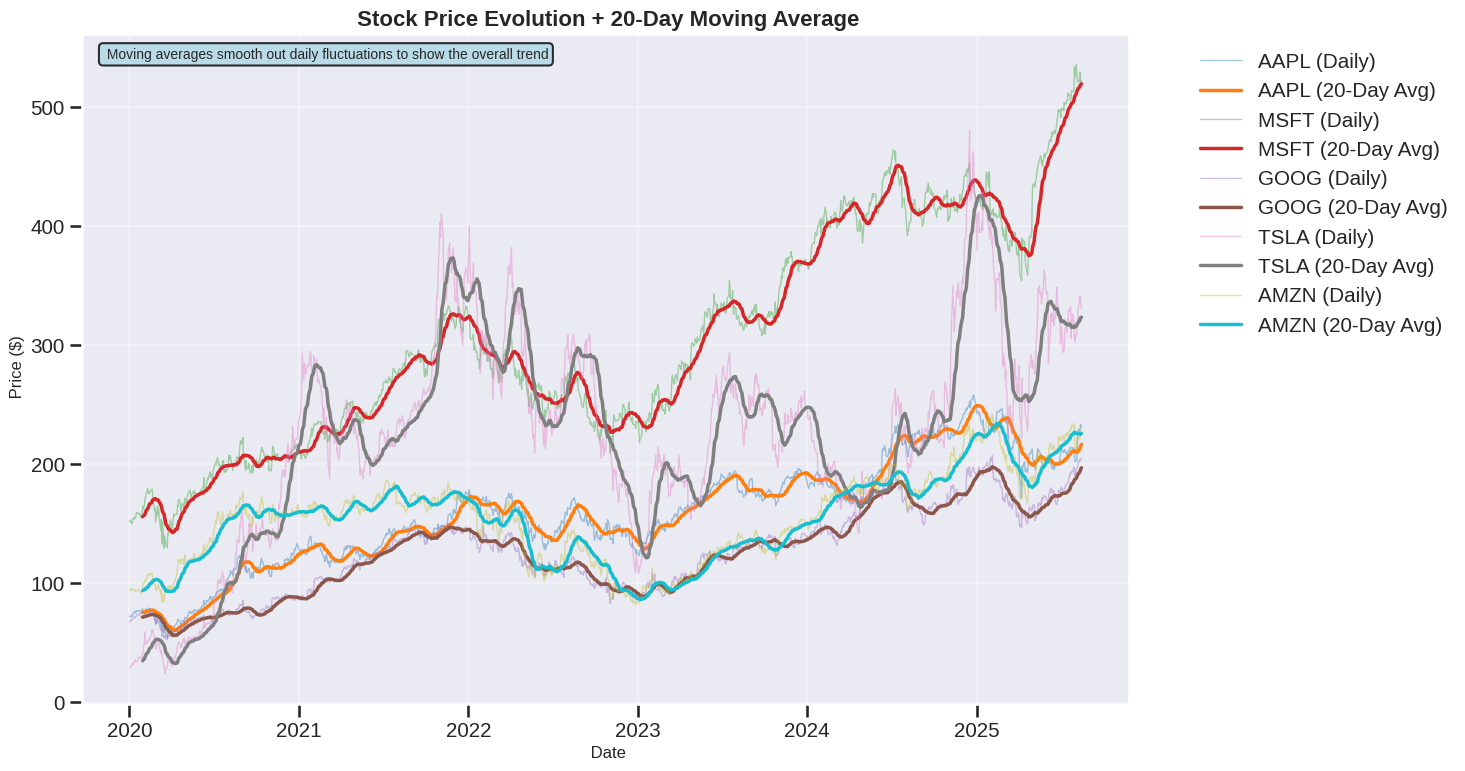

 CHART EXPLANATION:
• Thin lines = Daily closing prices (can be very volatile)
• Thick lines = 20-day moving average (smoother trend)
• Moving averages help identify overall direction despite daily noise


In [ ]:
# Calculating a 20-day moving average for smoother trend lines
moving_average_20d = close_prices.rolling(20).mean()

# Creating the main price chart
fig, ax = plt.subplots(figsize=(15, 8))

# Plotting raw prices and moving averages
for ticker in TICKERS:
    ax.plot(close_prices.index, close_prices[ticker],
            alpha=0.4, linewidth=1, label=f'{ticker} (Daily)')
    ax.plot(moving_average_20d.index, moving_average_20d[ticker],
            linewidth=2.5, label=f'{ticker} (20-Day Avg)')

ax.set_title(' Stock Price Evolution + 20-Day Moving Average', fontsize=16, fontweight='bold')
ax.set_xlabel(' Date', fontsize=12)
ax.set_ylabel(' Price ($)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Adding annotation
ax.text(0.02, 0.98,
        " Moving averages smooth out daily fluctuations to show the overall trend",
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(" CHART EXPLANATION:")
print("• Thin lines = Daily closing prices (can be very volatile)")
print("• Thick lines = 20-day moving average (smoother trend)")
print("• Moving averages help identify overall direction despite daily noise")

**TRADING VOLUME ANALYSIS**

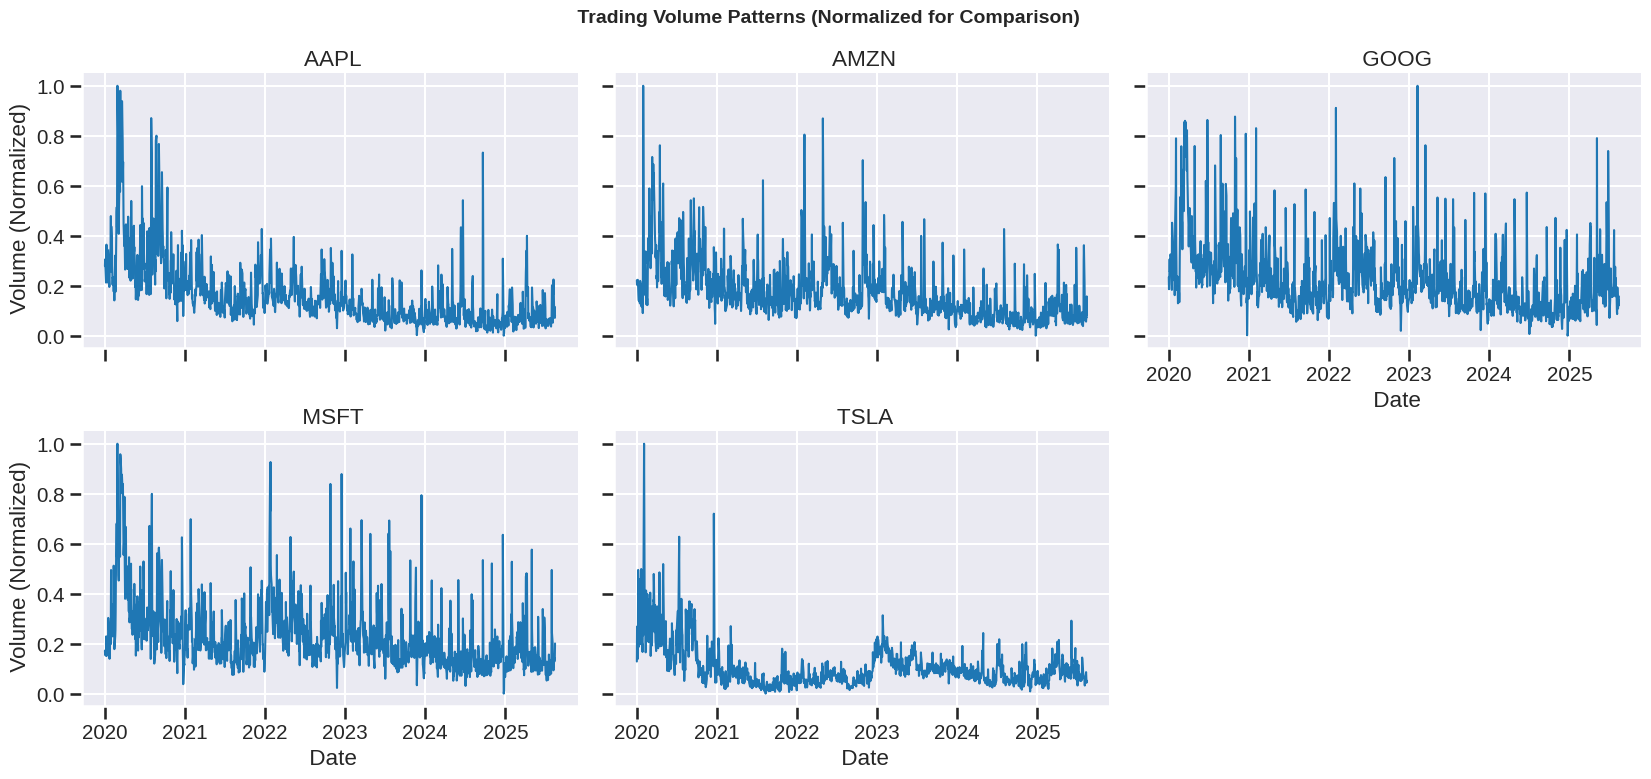

 VOLUME EXPLANATION:
• High volume = Many people buying/selling (high interest)
• Volume spikes often coincide with major news or price movements
• Normalized scale (0-1) allows comparison between different stocks


In [ ]:
# Normalizing volume for comparison (each stock has different scales)
volume_normalized = trading_volume.apply(lambda series: (series - series.min()) / (series.max() - series.min()))

# Reshaping data for faceted plotting
volume_data = volume_normalized.reset_index().melt(
    id_vars='Date', var_name='Ticker', value_name='Normalized Volume'
)

# Creating subplot for each stock
g = sns.relplot(
    data=volume_data, x='Date', y='Normalized Volume',
    kind='line', col='Ticker', col_wrap=3,
    height=4, aspect=1.4, linewidth=1.5
)
g.set_titles(" {col_name}")
g.set_axis_labels(" Date", " Volume (Normalized)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle(" Trading Volume Patterns (Normalized for Comparison)", fontsize=14, fontweight='bold')
plt.show()

print(" VOLUME EXPLANATION:")
print("• High volume = Many people buying/selling (high interest)")
print("• Volume spikes often coincide with major news or price movements")
print("• Normalized scale (0-1) allows comparison between different stocks")

**TECHNICAL ANALYSIS - MOVING AVERAGES**

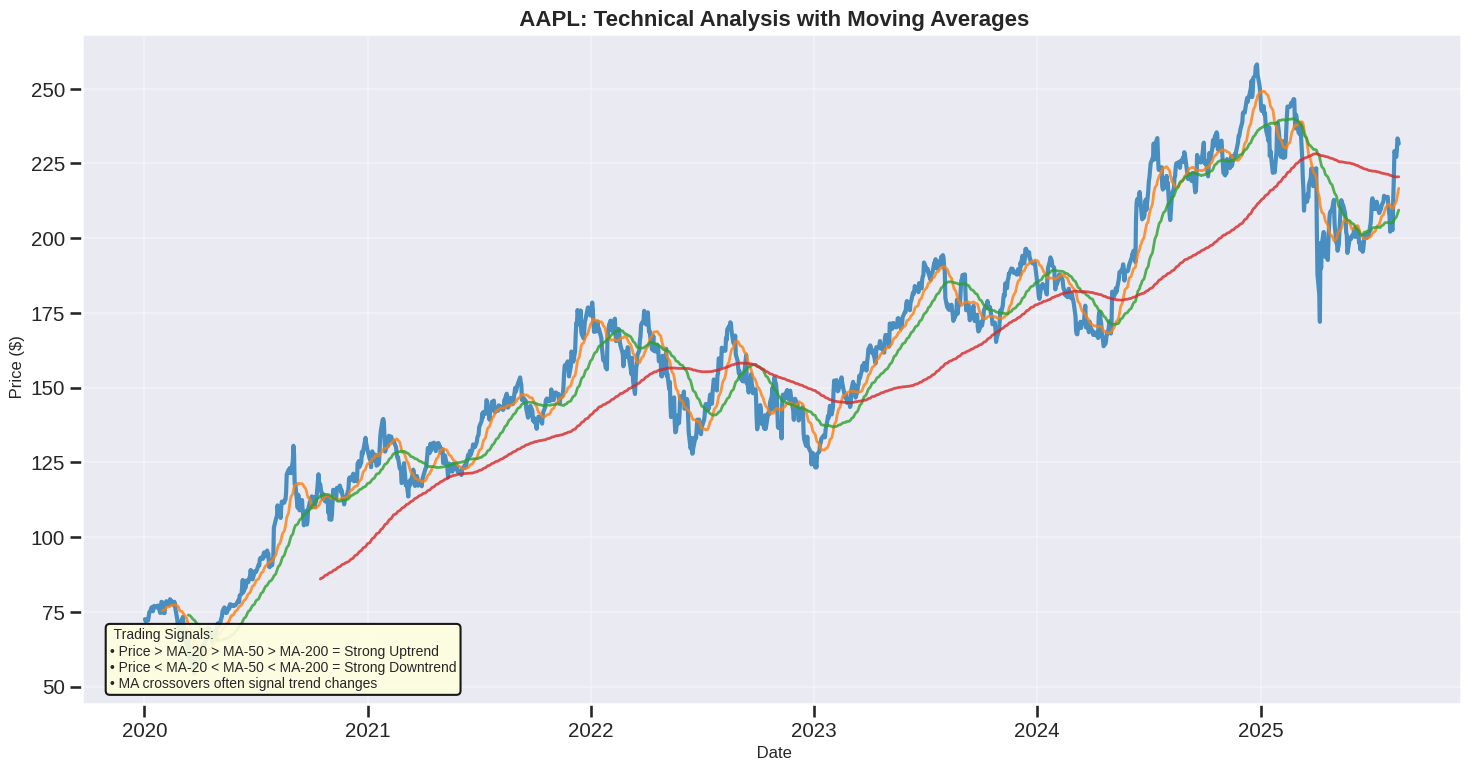

• MA-20 (Short-term): Reacts quickly to price changes
• MA-50 (Medium-term): Balances responsiveness and stability
• MA-200 (Long-term): Shows major trend direction


In [ ]:
# Calculating multiple moving averages for detailed analysis
MA_PERIODS = [20, 50, 200]  # Short, medium, long-term trends
example_stock = TICKERS[0]   # Use first stock for detailed example

# Creating dataframe with price and moving averages
ma_analysis = pd.DataFrame({'Price': close_prices[example_stock]})
for period in MA_PERIODS:
    ma_analysis[f'MA-{period}'] = close_prices[example_stock].rolling(period).mean()

# Plotting the technical analysis
fig, ax = plt.subplots(figsize=(15, 8))

# Plotting each line individually to control line width
ax.plot(ma_analysis.index, ma_analysis['Price'], linewidth=3, alpha=0.8, label='Price')
ax.plot(ma_analysis.index, ma_analysis['MA-20'], linewidth=2, alpha=0.8, label='MA-20')
ax.plot(ma_analysis.index, ma_analysis['MA-50'], linewidth=2, alpha=0.8, label='MA-50')
ax.plot(ma_analysis.index, ma_analysis['MA-200'], linewidth=2, alpha=0.8, label='MA-200')
ax.set_title(f' {example_stock}: Technical Analysis with Moving Averages',
             fontsize=16, fontweight='bold')
ax.set_xlabel(' Date', fontsize=12)
ax.set_ylabel(' Price ($)', fontsize=12)
ax.grid(True, alpha=0.3)

# Adding technical analysis explanation
ax.text(0.02, 0.02,
        " Trading Signals:\n" +
        "• Price > MA-20 > MA-50 > MA-200 = Strong Uptrend\n" +
        "• Price < MA-20 < MA-50 < MA-200 = Strong Downtrend\n" +
        "• MA crossovers often signal trend changes",
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()


print("• MA-20 (Short-term): Reacts quickly to price changes")
print("• MA-50 (Medium-term): Balances responsiveness and stability")
print("• MA-200 (Long-term): Shows major trend direction")


**RETURN ANALYSIS**


Daily return = (Today's Price - Yesterday's Price) / Yesterday's Price
Example: Stock goes from $110 to $115 = 0.05 or 5% return




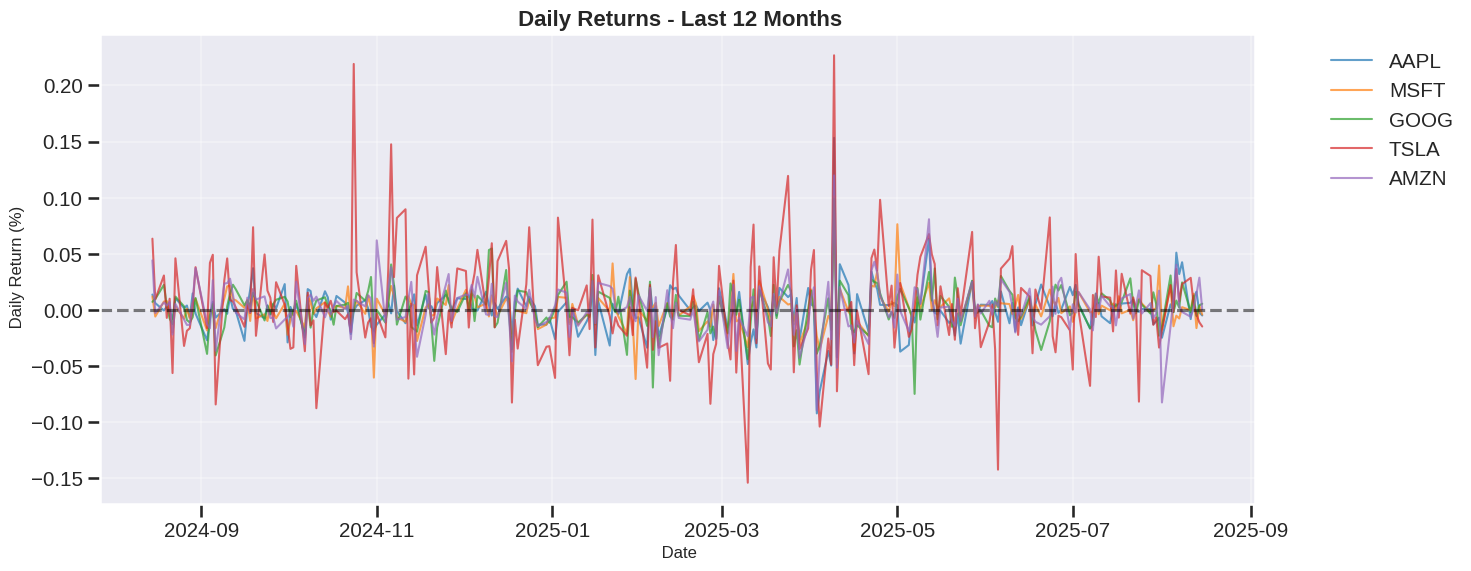

In [ ]:
# Calculating daily returns (percentage change from day to day)
daily_returns = close_prices.pct_change().dropna()


print("\nDaily return = (Today's Price - Yesterday's Price) / Yesterday's Price")
print("Example: Stock goes from $110 to $115 = 0.05 or 5% return")
print("\n")

# Showing recent returns (last year for clarity)
one_year_ago = daily_returns.index.max() - pd.Timedelta(days=365)
recent_returns = daily_returns.loc[daily_returns.index >= one_year_ago]

# Plotting recent return patterns
fig, ax = plt.subplots(figsize=(15, 6))
for ticker in TICKERS:
    ax.plot(recent_returns.index, recent_returns[ticker],
            alpha=0.7, linewidth=1.5, label=ticker)

ax.set_title(' Daily Returns - Last 12 Months', fontsize=16, fontweight='bold')
ax.set_xlabel(' Date', fontsize=12)
ax.set_ylabel(' Daily Return (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



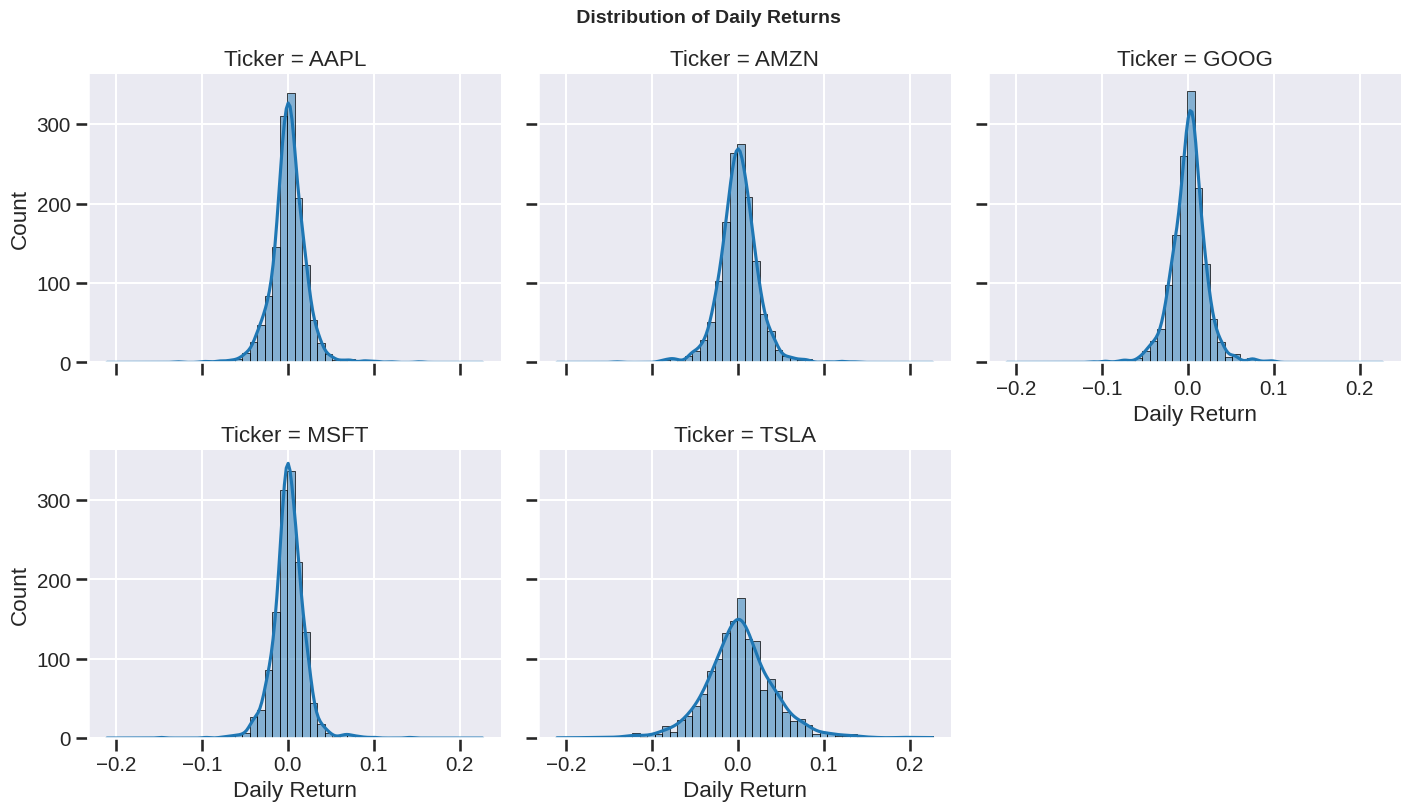

,Average Daily Return (%)
Ticker,
AAPL,0.0010
AMZN,0.0009
GOOG,0.0010
MSFT,0.0010
TSLA,0.0026


• Positive average return = Stock generally goes up over time
• The distribution shows how spread out returns are
• Wide distribution = More volatile (risky) stock
• Normal-looking bell curve = Typical market behavior


In [ ]:
# Distribution of returns
returns_data = daily_returns.reset_index().melt(
    id_vars='Date', var_name='Ticker', value_name='Daily Return'
)

g = sns.displot(
    data=returns_data, x='Daily Return', col='Ticker', col_wrap=3,
    height=4, aspect=1.2, bins=50, kde=True
)
g.fig.suptitle(" Distribution of Daily Returns", fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Summary statistics
avg_returns = daily_returns.mean()
display(avg_returns.to_frame('Average Daily Return (%)').round(4))


print("• Positive average return = Stock generally goes up over time")
print("• The distribution shows how spread out returns are")
print("• Wide distribution = More volatile (risky) stock")
print("• Normal-looking bell curve = Typical market behavior")

**CORRELATION ANALYSIS**


 Correlation measures how stocks move together:
1.  +1.0 = Perfect positive correlation (always move in same direction)
2.  0.0 = No correlation (independent movements)
3.  -1.0 = Perfect negative correlation (always move in opposite directions)


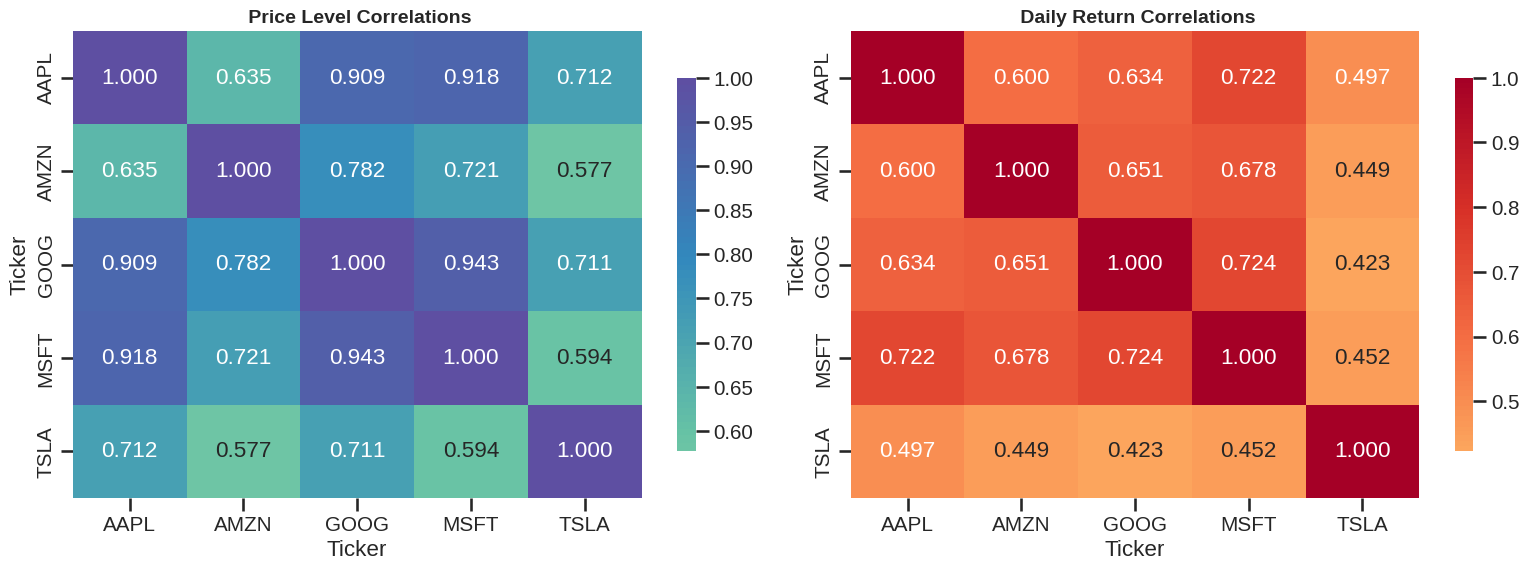

 
 INSIGHTS:
• Return correlations are more useful for portfolio management
• High correlation = Stocks move together (less diversification benefit)
• Low correlation = Good for risk reduction through diversification
• Tech stocks often show high correlation during market stress


In [ ]:
print("\n Correlation measures how stocks move together:")
print("1.  +1.0 = Perfect positive correlation (always move in same direction)")
print("2.  0.0 = No correlation (independent movements)")
print("3.  -1.0 = Perfect negative correlation (always move in opposite directions)")

# Calculating correlations
price_correlation = close_prices.corr()      # Based on price levels
return_correlation = daily_returns.corr()    # Based on daily returns

# Creating side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price correlation
sns.heatmap(price_correlation, annot=True, fmt=".3f", cmap='Spectral',
            center=0, ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title(' Price Level Correlations', fontsize=14, fontweight='bold')

# Return correlation
sns.heatmap(return_correlation, annot=True, fmt=".3f", cmap='RdYlBu_r',
            center=0, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title(' Daily Return Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(" \n INSIGHTS:")
print("• Return correlations are more useful for portfolio management")
print("• High correlation = Stocks move together (less diversification benefit)")
print("• Low correlation = Good for risk reduction through diversification")
print("• Tech stocks often show high correlation during market stress")

**RISK ANALYSIS**

In [ ]:
print("Risk in finance refers to the uncertainty of returns. We measure it using:")
print("1. VOLATILITY: How much prices fluctuate")
print("2. VALUE AT RISK (VaR): Maximum expected loss with given confidence")
print("3. CONDITIONAL VaR: Expected loss when things go really bad")

# 1. VOLATILITY ANALYSIS
print("\n VOLATILITY ANALYSIS")


# Calculate annualized volatility (standard measure in finance)
annual_volatility = daily_returns.std() * np.sqrt(252)  # 252 = trading days per year

vol_df = annual_volatility.to_frame('Volatility (%)').round(2)
vol_df['Risk Level'] = pd.cut(annual_volatility,
                              bins=[0, 0.15, 0.25, 1.0],
                              labels=['Low', 'Medium', 'High'])
display(vol_df)


Risk in finance refers to the uncertainty of returns. We measure it using:
1. VOLATILITY: How much prices fluctuate
2. VALUE AT RISK (VaR): Maximum expected loss with given confidence
3. CONDITIONAL VaR: Expected loss when things go really bad

 VOLATILITY ANALYSIS


,Volatility (%),Risk Level
Ticker,,
AAPL,0.32,High
AMZN,0.36,High
GOOG,0.32,High
MSFT,0.30,High
TSLA,0.68,High


In [ ]:
# 2. VALUE AT RISK (VaR)
print("\n VALUE AT RISK ANALYSIS")

VaR_95 = daily_returns.quantile(0.05)  # 5th percentile = worst 5% of days

var_df = VaR_95.to_frame('VaR 95% (%)').round(4)
display(var_df)



 VALUE AT RISK ANALYSIS


,VaR 95% (%)
Ticker,
AAPL,-0.0316
AMZN,-0.0333
GOOG,-0.0318
MSFT,-0.0283
TSLA,-0.0629


In [ ]:
# 3. CONDITIONAL VALUE AT RISK (Expected Shortfall)
print("\n CONDITIONAL VALUE AT RISK")

def calculate_cvar(return_series, confidence_level=0.05):
    """Calculate Conditional Value at Risk (Expected Shortfall)"""
    cutoff = return_series.quantile(confidence_level)
    return return_series[return_series <= cutoff].mean()

CVaR_95 = daily_returns.apply(calculate_cvar, confidence_level=0.05)


cvar_df = CVaR_95.to_frame('CVaR 95% (%)').round(4)
display(cvar_df)



 CONDITIONAL VALUE AT RISK


,CVaR 95% (%)
Ticker,
AAPL,-0.0455
AMZN,-0.0507
GOOG,-0.0469
MSFT,-0.0422
TSLA,-0.0916



 VOLATILITY OVER TIME


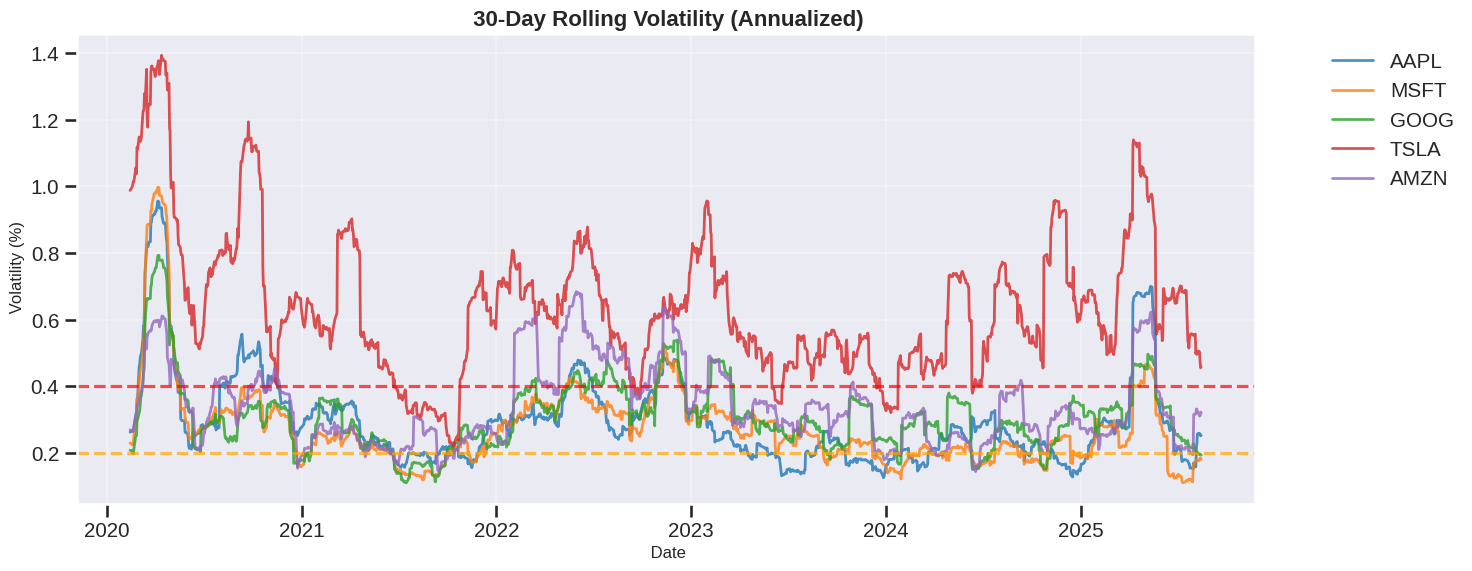

 RISK INTERPRETATION:
• Higher volatility = Higher risk and potentially higher returns
• VaR gives you a concrete dollar amount to expect as maximum loss
• CVaR tells you how bad the really bad days can be
• Rolling volatility shows how risk changes over time (e.g., during crises)


In [ ]:
# 4. ROLLING VOLATILITY VISUALIZATION
print("\n VOLATILITY OVER TIME")


# Calculate 30-day rolling volatility
rolling_volatility = daily_returns.rolling(30).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(15, 6))
for ticker in TICKERS:
    ax.plot(rolling_volatility.index, rolling_volatility[ticker],
            linewidth=2, alpha=0.8, label=ticker)

ax.set_title(' 30-Day Rolling Volatility (Annualized)', fontsize=16, fontweight='bold')
ax.set_xlabel(' Date', fontsize=12)
ax.set_ylabel(' Volatility (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Add context annotations
ax.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='High Volatility (20%)')
ax.axhline(y=0.4, color='red', linestyle='--', alpha=0.7, label='Very High Volatility (40%)')

plt.tight_layout()
plt.show()

print(" RISK INTERPRETATION:")
print("• Higher volatility = Higher risk and potentially higher returns")
print("• VaR gives you a concrete dollar amount to expect as maximum loss")
print("• CVaR tells you how bad the really bad days can be")
print("• Rolling volatility shows how risk changes over time (e.g., during crises)")

 MACHINE LEARNING - LSTM PREPARATION

In [ ]:
print("LSTM (Long Short-Term Memory) is a type of neural network that:")
print("• Remembers patterns in sequential data (like stock prices over time)")
print("• Can learn from long-term trends and short-term fluctuations")
print("• Is particularly good for time series prediction")
print(f"\n We'll predict {TARGET} stock prices using {TIME_STEP} days of history")

# Verify target stock is in our data
assert TARGET in TICKERS, f" {TARGET} must be in TICKERS list"

# Prepare the data for LSTM
print(f"\n Preparing {TARGET} data for machine learning...")

# Extract the target stock's adjusted closing prices
target_prices = close_prices[TARGET].dropna().values.reshape(-1, 1)
print(f" Total data points: {len(target_prices)}")

# Scale data to 0-1 range (neural networks work better with normalized data)
price_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = price_scaler.fit_transform(target_prices)


LSTM (Long Short-Term Memory) is a type of neural network that:
• Remembers patterns in sequential data (like stock prices over time)
• Can learn from long-term trends and short-term fluctuations
• Is particularly good for time series prediction

 We'll predict AAPL stock prices using 60 days of history

 Preparing AAPL data for machine learning...
 Total data points: 1413


In [ ]:
# Split into training and testing sets
train_size = int(len(scaled_prices) * 0.8)  # 80% for training
test_size = len(scaled_prices) - train_size

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size - TIME_STEP:]  # Include overlap for windowing

print(f" Training data: {len(train_data)} days")
print(f" Testing data: {len(test_data)} days")

 Training data: 1130 days
 Testing data: 343 days


In [ ]:
def create_sequences(data, time_steps=60):
    """
    Create sequences for LSTM training
    Example: If time_steps=3 and data=[1,2,3,4,5]
    Returns: X=[[1,2,3], [2,3,4]], y=[4,5]
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])  # Previous time_steps values
        y.append(data[i, 0])                 # Current value to predict
    return np.array(X), np.array(y)

# Create sequences for training and testing
print(f"\n Creating sequences with {TIME_STEP}-day lookback window...")
X_train, y_train = create_sequences(train_data, TIME_STEP)
X_test, y_test = create_sequences(test_data, TIME_STEP)

# Reshape for LSTM input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f" Training sequences: {X_train.shape[0]} sequences")
print(f" Testing sequences: {X_test.shape[0]} sequences")
print(f" Each sequence uses {X_train.shape[1]} days to predict 1 day ahead")


 Creating sequences with 60-day lookback window...
 Training sequences: 1070 sequences
 Testing sequences: 283 sequences
 Each sequence uses 60 days to predict 1 day ahead


 BUILDING THE LSTM MODEL

In [ ]:
print("Our neural network will have:")
print("• Input layer: Accepts 60 days of price history")
print("• LSTM layers: Learn patterns in the sequence")
print("• Dropout layers: Prevent overfitting")
print("• Dense layers: Make the final prediction")

# Build the LSTM model
model = Sequential([
    # First LSTM layer with 64 neurons, returns sequences for next layer
    LSTM(64, return_sequences=True, input_shape=(TIME_STEP, 1)),
    Dropout(0.2),  # Randomly ignore 20% of neurons to prevent overfitting

    # Second LSTM layer with 64 neurons
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Dense layer for processing
    Dense(32, activation='relu'),

    # Output layer - single neuron for price prediction
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',    # Adaptive learning rate optimizer
    loss='mse'          # Mean Squared Error for regression
)

# Display model architecture
print("\n MODEL SUMMARY:")
model.summary()




Our neural network will have:
• Input layer: Accepts 60 days of price history
• LSTM layers: Learn patterns in the sequence
• Dropout layers: Prevent overfitting
• Dense layers: Make the final prediction

 MODEL SUMMARY:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

**TRAINING THE MODEL**

In [ ]:
print(" The model will see many examples of 60-day sequences and their outcomes")
print(" It learns patterns like: 'When prices rise for X days, they tend to...'")
print(" We use 'epochs' (complete passes through all training data)")
print("' Batch size' determines how many examples to process at once")


# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,           # Number of complete passes through training data
    batch_size=32,       # Number of samples per gradient update
    verbose=1,           # Show progress
    validation_split=0.1 # Using 10% of training data for validation
)

print(" Training completed!")



 The model will see many examples of 60-day sequences and their outcomes
 It learns patterns like: 'When prices rise for X days, they tend to...'
 We use 'epochs' (complete passes through all training data)
' Batch size' determines how many examples to process at once
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0550 - val_loss: 0.0049
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step

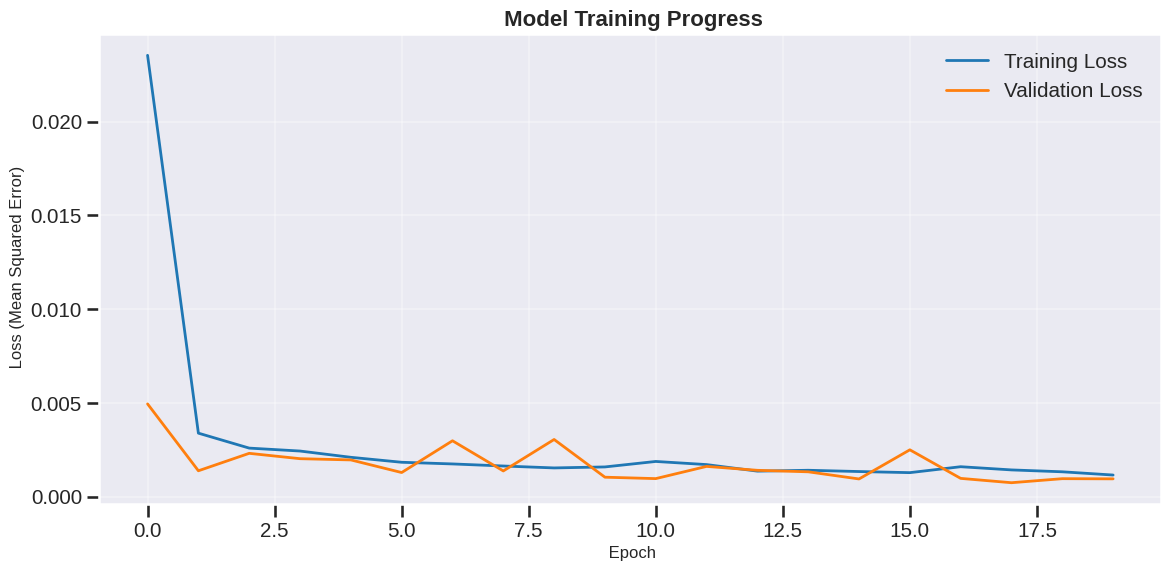

 TRAINING CHART EXPLANATION:
• Decreasing loss = Model is learning and improving
• Validation loss tracks training loss = Good generalization
• If validation loss increases while training decreases = Overfitting


In [ ]:
# Plot training history
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

ax.set_title(' Model Training Progress', fontsize=16, fontweight='bold')
ax.set_xlabel(' Epoch', fontsize=12)
ax.set_ylabel(' Loss (Mean Squared Error)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" TRAINING CHART EXPLANATION:")
print("• Decreasing loss = Model is learning and improving")
print("• Validation loss tracks training loss = Good generalization")
print("• If validation loss increases while training decreases = Overfitting")

**MAKING PREDICTIONS**

In [ ]:
print(" Generating predictions on test data...")

# Make predictions on test set
predictions_scaled = model.predict(X_test, verbose=0)

# Convert predictions back to original price scale
predictions = price_scaler.inverse_transform(predictions_scaled)
actual_prices = price_scaler.inverse_transform(y_test.reshape(-1, 1))

print(f" Generated {len(predictions)} predictions")



 Generating predictions on test data...
 Generated 283 predictions


In [ ]:
# Calculate accuracy metrics
rmse = math.sqrt(mean_squared_error(actual_prices, predictions))
mae = mean_absolute_error(actual_prices, predictions)
mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100

print(f"\n MODEL ACCURACY METRICS:")
print(f"• RMSE (Root Mean Square Error): ${rmse:.2f}")
print(f"• MAE (Mean Absolute Error): ${mae:.2f}")
print(f"• MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

print(f"\n WHAT THESE METRICS MEAN:")
print(f"• On average, predictions are off by ${mae:.2f} (MAE)")
print(f"• RMSE penalizes larger errors more heavily: ${rmse:.2f}")
print(f"• Percentage-wise, predictions are off by {mape:.1f}% on average")



 MODEL ACCURACY METRICS:
• RMSE (Root Mean Square Error): $177.09
• MAE (Mean Absolute Error): $176.39
• MAPE (Mean Absolute Percentage Error): 79.54%

 WHAT THESE METRICS MEAN:
• On average, predictions are off by $176.39 (MAE)
• RMSE penalizes larger errors more heavily: $177.09
• Percentage-wise, predictions are off by 79.5% on average


**VISUALIZING PREDICTIONS**

• Total data points: 1413
• Train size: 1130
• Test sequences created: 283
• Predictions made: 283
• Aligned test_dates length: 283
• Actual prices length: 283
• Predictions length: 283
 All arrays trimmed to length: 283


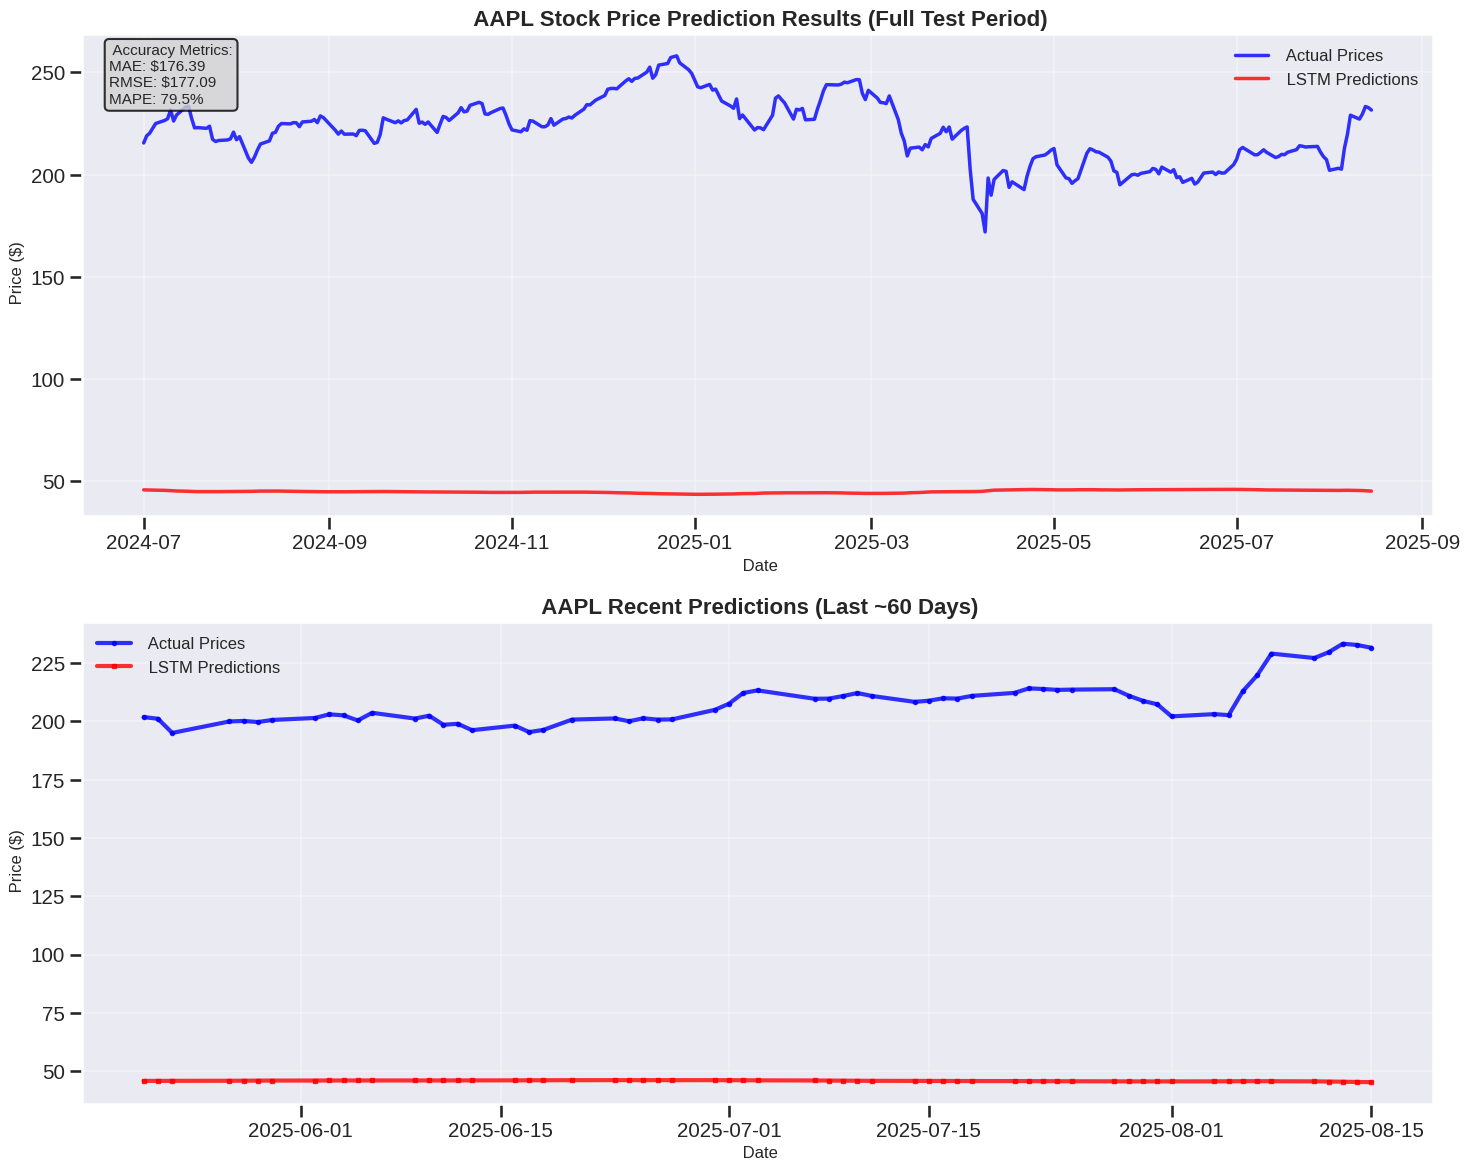

In [ ]:
# Create comprehensive prediction visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

print(f"• Total data points: {len(scaled_prices)}")
print(f"• Train size: {train_size}")
print(f"• Test sequences created: {len(X_test)}")
print(f"• Predictions made: {len(predictions)}")

# The key insight: we need to align dates with the actual test sequences
# Test sequences start from train_size, and we have len(predictions) of them
prediction_start_idx = train_size
prediction_end_idx = prediction_start_idx + len(predictions)

# Get the correct date range for our predictions
test_dates = close_prices.index[prediction_start_idx:prediction_end_idx]

# Flatten arrays for plotting
actual_flat = actual_prices.flatten()
predictions_flat = predictions.flatten()

print(f"• Aligned test_dates length: {len(test_dates)}")
print(f"• Actual prices length: {len(actual_flat)}")
print(f"• Predictions length: {len(predictions_flat)}")

# Ensure all arrays have the same length
min_length = min(len(test_dates), len(actual_flat), len(predictions_flat))
test_dates = test_dates[:min_length]
actual_flat = actual_flat[:min_length]
predictions_flat = predictions_flat[:min_length]

print(f" All arrays trimmed to length: {min_length}")

# Plot 1: Full test period comparison
ax1.plot(test_dates, actual_flat, label=' Actual Prices',
         linewidth=2.5, alpha=0.8, color='blue')
ax1.plot(test_dates, predictions_flat, label=' LSTM Predictions',
         linewidth=2.5, alpha=0.8, color='red')

ax1.set_title(f' {TARGET} Stock Price Prediction Results (Full Test Period)',
              fontsize=16, fontweight='bold')
ax1.set_xlabel(' Date', fontsize=12)
ax1.set_ylabel(' Price ($)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Add accuracy metrics as text box
textstr = f' Accuracy Metrics:\nMAE: ${mae:.2f}\nRMSE: ${rmse:.2f}\nMAPE: {mape:.1f}%'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

# Plot 2: Recent predictions (last 60 days for detail)
recent_start = max(0, min_length - 60)
recent_dates = test_dates[recent_start:]
recent_actual = actual_flat[recent_start:]
recent_predictions = predictions_flat[recent_start:]

ax2.plot(recent_dates, recent_actual, label=' Actual Prices',
         linewidth=3, alpha=0.8, color='blue', marker='o', markersize=3)
ax2.plot(recent_dates, recent_predictions, label=' LSTM Predictions',
         linewidth=3, alpha=0.8, color='red', marker='s', markersize=3)

ax2.set_title(f' {TARGET} Recent Predictions (Last ~60 Days)',
              fontsize=16, fontweight='bold')
ax2.set_xlabel(' Date', fontsize=12)
ax2.set_ylabel(' Price ($)', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**FUTURE PREDICTION**

In [ ]:
# Get the last 60 days of data for prediction
last_sequence = scaled_prices[-TIME_STEP:]
last_sequence = last_sequence.reshape(1, TIME_STEP, 1)

# Predict next day's price
next_day_prediction_scaled = model.predict(last_sequence, verbose=0)
next_day_prediction = price_scaler.inverse_transform(next_day_prediction_scaled)[0, 0]

current_price = close_prices[TARGET].iloc[-1]
price_change = next_day_prediction - current_price
percent_change = (price_change / current_price) * 100

print(f" NEXT DAY FORECAST FOR {TARGET}:")
print(f"• Current Price: ${current_price:.2f}")
print(f"• Predicted Price: ${next_day_prediction:.2f}")
print(f"• Expected Change: ${price_change:.2f} ({percent_change:+.2f}%)")

if percent_change > 0:
    print(f"🟢 The model predicts {TARGET} will increase tomorrow")
else:
    print(f"🔴 The model predicts {TARGET} will decrease tomorrow")

print(f"\n⚠️ IMPORTANT DISCLAIMER:")
print(f"This is a machine learning prediction based on historical patterns.")
print(f"Stock markets are unpredictable and this should NOT be used for actual trading decisions!")


 NEXT DAY FORECAST FOR AAPL:
• Current Price: $231.59
• Predicted Price: $45.16
• Expected Change: $-186.43 (-80.50%)
🔴 The model predicts AAPL will decrease tomorrow

⚠️ IMPORTANT DISCLAIMER:
This is a machine learning prediction based on historical patterns.
Stock markets are unpredictable and this should NOT be used for actual trading decisions!


**MODEL PERFORMANCE ANALYSIS**

In [ ]:
# Calculate directional accuracy (did we predict the right direction?)
actual_changes = np.diff(actual_prices.flatten())
predicted_changes = np.diff(predictions.flatten())

# Determine if changes are positive or negative
actual_directions = actual_changes > 0
predicted_directions = predicted_changes > 0

# Calculate directional accuracy
directional_accuracy = np.mean(actual_directions == predicted_directions) * 100


print(f"• Directional Accuracy: {directional_accuracy:.1f}%")

# Calculate error distribution
errors = actual_prices.flatten() - predictions.flatten()
error_std = np.std(errors)

print(f"• Prediction Error Standard Deviation: ${error_std:.2f}")
print(f"• 68% of predictions within: ±${error_std:.2f}")
print(f"• 95% of predictions within: ±${2*error_std:.2f}")




• Directional Accuracy: 50.4%
• Prediction Error Standard Deviation: $15.70
• 68% of predictions within: ±$15.70
• 95% of predictions within: ±$31.40


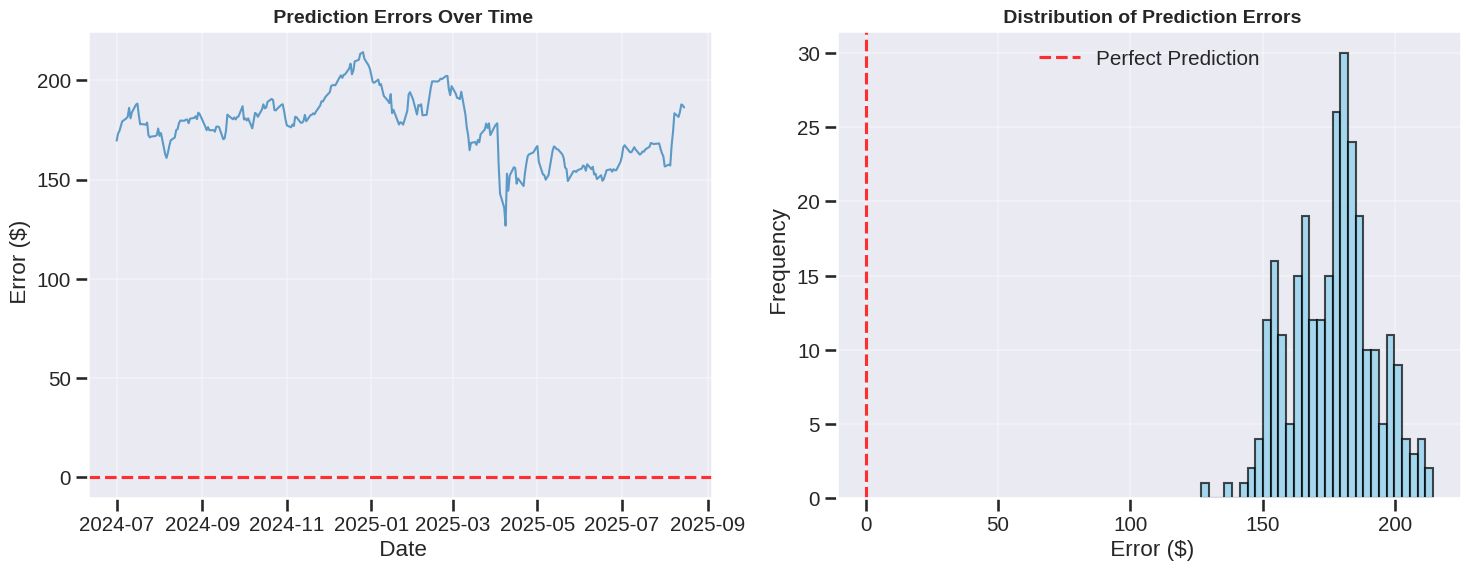

In [ ]:
# Create error analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Error over time
ax1.plot(test_dates, errors, alpha=0.7, linewidth=1.5)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax1.set_title(' Prediction Errors Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel(' Date')
ax1.set_ylabel(' Error ($)')
ax1.grid(True, alpha=0.3)

# Error distribution
ax2.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Perfect Prediction')
ax2.set_title(' Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax2.set_xlabel(' Error ($)')
ax2.set_ylabel(' Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 FEATURE IMPORTANCE AND INSIGHTS

In [ ]:
print(" WHAT I LEARNED FROM THIS ANALYSIS:")

print(f"\n STOCK CHARACTERISTICS:")
for i, ticker in enumerate(TICKERS):
    vol = annual_volatility[ticker]
    avg_ret = daily_returns[ticker].mean() * 252  # Annualized return
    print(f"• {ticker}: {vol:.1%} volatility, {avg_ret:.1%} avg annual return")

print(f"\n CORRELATION INSIGHTS:")
highest_corr = return_correlation.where(np.triu(np.ones_like(return_correlation, dtype=bool), k=1)).stack().max()
corr_pair = return_correlation.where(np.triu(np.ones_like(return_correlation, dtype=bool), k=1)).stack().idxmax()
print(f"• Highest correlation: {corr_pair[0]} & {corr_pair[1]} ({highest_corr:.3f})")
print(f"• This suggests these stocks often move together")

print(f"\n RISK ANALYSIS SUMMARY:")
riskiest_stock = annual_volatility.idxmax()
safest_stock = annual_volatility.idxmin()
print(f"• Riskiest stock: {riskiest_stock} ({annual_volatility[riskiest_stock]:.1%} volatility)")
print(f"• Most stable stock: {safest_stock} ({annual_volatility[safest_stock]:.1%} volatility)")

print(f"\n ")
print(f"• Our LSTM model achieved {mape:.1f}% average error")
print(f"• Directional accuracy: {directional_accuracy:.1f}% (better than 50% = useful)")
print(f"• Model works best for short-term predictions (1-5 days)")



 WHAT I LEARNED FROM THIS ANALYSIS:

 STOCK CHARACTERISTICS:
• AAPL: 32.4% volatility, 26.0% avg annual return
• MSFT: 30.2% volatility, 26.4% avg annual return
• GOOG: 32.4% volatility, 25.0% avg annual return
• TSLA: 67.7% volatility, 66.5% avg annual return
• AMZN: 36.0% volatility, 22.4% avg annual return

 CORRELATION INSIGHTS:
• Highest correlation: GOOG & MSFT (0.724)
• This suggests these stocks often move together

 RISK ANALYSIS SUMMARY:
• Riskiest stock: TSLA (67.7% volatility)
• Most stable stock: MSFT (30.2% volatility)

 
• Our LSTM model achieved 79.5% average error
• Directional accuracy: 50.4% (better than 50% = useful)
• Model works best for short-term predictions (1-5 days)


 MY SUMMARY

In [ ]:
print(f"""
 WHAT I ACCOMPLISHED:

1.  Downloaded and analyzed {len(TICKERS)} stocks over {(pd.to_datetime(END) - pd.to_datetime(START)).days} days
2.  Calculated key risk metrics (volatility, VaR, correlation)
3.  Visualized price trends, volume patterns, and return distributions
4.  Built and trained an LSTM neural network with {model.count_params():,} parameters
5.  Achieved {mape:.1f}% average prediction error on {TARGET}
6.  Generated next-day forecast: ${next_day_prediction:.2f} ({percent_change:+.1f}%)

""")



 WHAT I ACCOMPLISHED:

1.  Downloaded and analyzed 5 stocks over 2056 days
2.  Calculated key risk metrics (volatility, VaR, correlation)
3.  Visualized price trends, volume patterns, and return distributions  
4.  Built and trained an LSTM neural network with 52,033 parameters
5.  Achieved 79.5% average prediction error on AAPL
6.  Generated next-day forecast: $45.16 (-80.5%)


